---

<h1 align="center">A Million News Headlines</h1>

> ### *Data:* 
   A Million News Headlines
> ### *Describtion:*
   News headlines published over a period of 19 Years
> ### *Source:*
   https://www.kaggle.com/datasets/therohk/million-headlines

### A. Importing all the necessary libraries
It is of good practice to start with loading all the libraries that are needed troughout the analysis. 

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from IPython.display import display
from tqdm import tqdm
import ast
import html

import collections
from collections import Counter
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sn
import scipy.stats as stats
import statistics as stat
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

Loading BokehJS ...

# 1. Question
#### What can the headlines from the Australian national broadcaster (the ABC) tell us about the concerns of the Australian public over time?


Using this dataset we want to know what are the most common words in the news headlines from 2003 until the end of 2021. These common words will be a measure of what are the main topics of newsheadlines reported by the latgest news corporation in Australia. This, in turn, could be used to understand what Australians were most concerned about during this period.

# 2. Data

## 2.1 Loading the data and naming it
Reading the file containing our dataset and calling it into a pandas object (simple and intuitive name is prefered)

In [5]:
headlines = pd.read_csv("abcnews-date-text.csv", parse_dates=[0], infer_datetime_format=True)

The column **publish_date** is actually a date entry but is stored as integer.
We can ask pandas to pars the date from this column and turn it to datetime type and set it as index.

## 2.2 Displaying the data and intital visual inspection
Before proceeding any further it is necessary to have a glance at the dataset to see what does it look like.

In [6]:
headlines.head() # just calling the name will return few rows and columns from the top and end of our table.

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


In [7]:
headlines.shape

(1244184, 2)

In [8]:
headlines.dtypes

publish_date     datetime64[ns]
headline_text            object
dtype: object

In [9]:
# lets check if there are any empty headlines
headlines.isnull().any().sum()

0

In [10]:
headlines[headlines.duplicated()]

,publish_date,headline_text
1232754,2021-03-01,house prices record sharpest increase since 2003
1237050,2021-06-01,house prices reach record levels; as investors


visual inspection shows that these two headlines are not quite the same and they are three months apart.
Therefore we treat them as not duplicates.

# 3. Analysis

## 3.1 Articles length

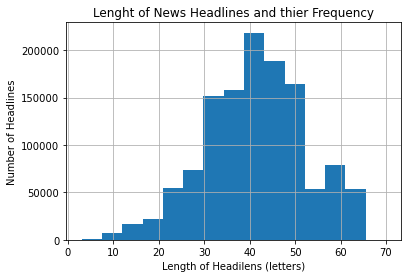

In [11]:
#checking to see how long the headlines are. The number of letters.
headlines["headline_text"].str.len().hist(bins = 15)
plt.title("Lenght of News Headlines and thier Frequency")
plt.xlabel("Length of Headilens (letters)", fontsize = 10)
plt.ylabel("Number of Headlines")
plt.show()

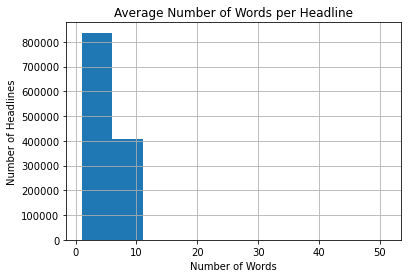

In [12]:
#checking to see the average number of words for headlines
headlines["headline_text"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.title("Average Number of Words per Headline")
plt.xlabel("Number of Words")
plt.ylabel("Number of Headlines")
plt.show()

## 3.2 Extracting Date Elements

Since we want to analyse the frequency of words over the years, it is a good idea to extract the year, month and day of each article into seperate columns.

In [13]:
headlines["Year"] = headlines["publish_date"].dt.year
headlines["Month"] = headlines["publish_date"].dt.month
headlines["Day"] = headlines["publish_date"].dt.day

In [14]:
headlines.head()

,publish_date,headline_text,Year,Month,Day
0,2003-02-19,aba decides against community broadcasting lic...,2003,2,19
1,2003-02-19,act fire witnesses must be aware of defamation,2003,2,19
2,2003-02-19,a g calls for infrastructure protection summit,2003,2,19
3,2003-02-19,air nz staff in aust strike for pay rise,2003,2,19
4,2003-02-19,air nz strike to affect australian travellers,2003,2,19


In [15]:
headlines.dtypes

publish_date     datetime64[ns]
headline_text            object
Year                      int64
Month                     int64
Day                       int64
dtype: object

In [16]:
headlines.set_index("Year")

,publish_date,headline_text,Month,Day
Year,,,,
2003,2003-02-19,aba decides against community broadcasting lic...,2,19
2003,2003-02-19,act fire witnesses must be aware of defamation,2,19
2003,2003-02-19,a g calls for infrastructure protection summit,2,19
2003,2003-02-19,air nz staff in aust strike for pay rise,2,19
2003,2003-02-19,air nz strike to affect australian travellers,2,19
...,...,...,...,...
2021,2021-12-31,two aged care residents die as state records 2...,12,31
2021,2021-12-31,victoria records 5;919 new cases and seven deaths,12,31
2021,2021-12-31,wa delays adopting new close contact definition,12,31


### 3.3 Aggregating data

To be able to analyse the data for month and day seperately we need to creat new dataframes from original data by grouping them based on the month and day.

In [17]:
month_grouped = headlines.groupby(["Month"])["headline_text"].count()
day_grouped = headlines.groupby(["Day"])["headline_text"].count()

In [18]:
year_grouped = headlines.groupby(["Year"])["headline_text"].count()

In [19]:
month_grouped

Month
1      92912
2      99175
3     111187
4     102740
5     109513
6     104643
7     108031
8     110313
9      99958
10    105620
11    104854
12     95238
Name: headline_text, dtype: int64

In [20]:
day_grouped

Day
1     39954
2     40018
3     40346
4     40603
5     40492
6     40081
7     41190
8     41268
9     40724
10    41244
11    41423
12    41036
13    41037
14    41389
15    41891
16    41563
17    41582
18    41467
19    41577
20    41570
21    41666
22    41981
23    41701
24    41101
25    39058
26    39465
27    40418
28    40255
29    37780
30    37223
31    23081
Name: headline_text, dtype: int64

In [21]:
year_grouped

Year
2003    63997
2004    72674
2005    73124
2006    66901
2007    77174
2008    79991
2009    76444
2010    74931
2011    77778
2012    89008
2013    91928
2014    81531
2015    77290
2016    61574
2017    47511
2018    40102
2019    34060
2020    40240
2021    17926
Name: headline_text, dtype: int64

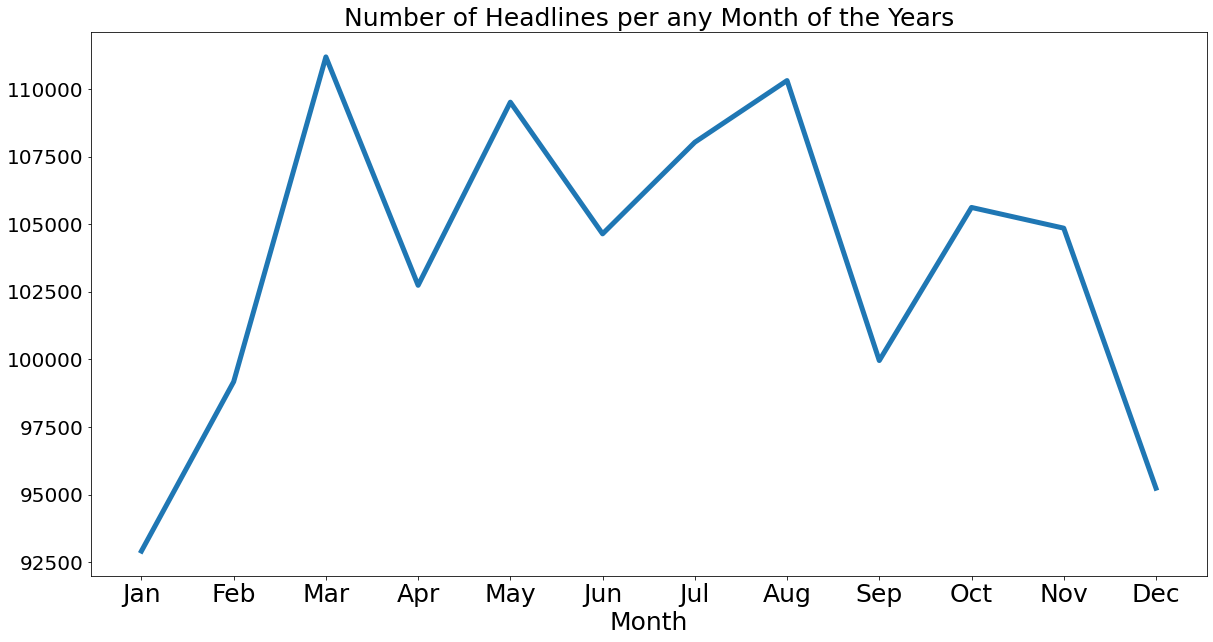

In [22]:
# Plotting the number of articles for each month of the year (2003-2021)
Mf = pd.Series(month_grouped)
Mf.plot(kind="line", linewidth = 5, figsize=(20,10))
plt.xticks(np.arange(1,13,1), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", 
                                      "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title(label = "Number of Headlines per any Month of the Years",
         fontsize = 25)
plt.xlabel("Month", fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=20)
plt.show()

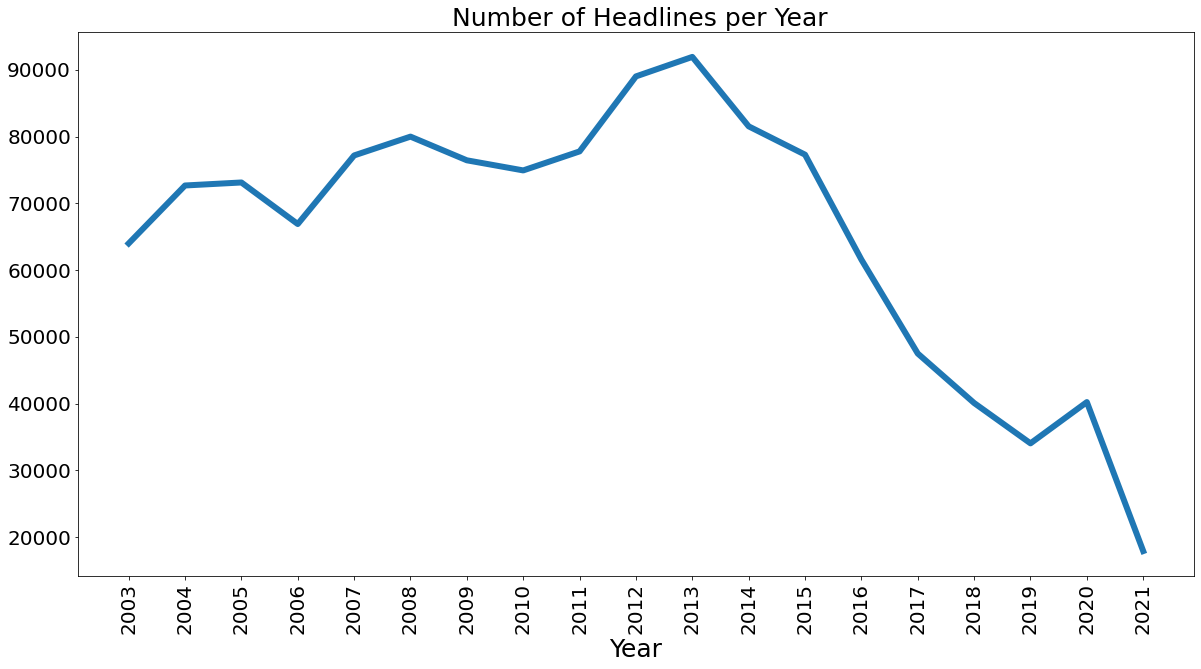

In [23]:
##### Plotting the number of articles for each year (2003-2021)

Yf = pd.Series(year_grouped)
Yf.plot(kind="line", linewidth = 6, figsize=(20,10))
plt.title(label = " Number of Headlines per Year", size = 25)
plt.xticks(np.arange(2003,2022,1),fontsize=20, rotation = 90)
plt.xlabel("Year", fontsize = 25)
plt.yticks(fontsize=20)
plt.show()

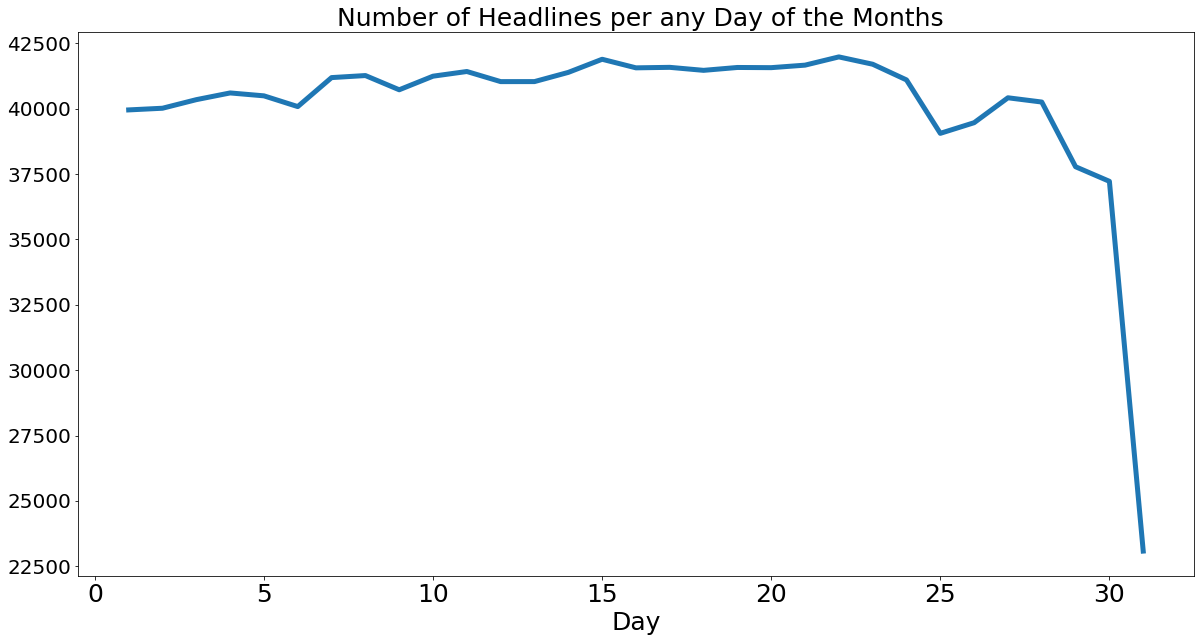

In [24]:
# Plotting the number of articles for each day of the month (2003-2021)
Df = pd.Series(day_grouped)
Df.plot(kind="line", linewidth = 5, figsize=(20,10))
plt.title(label = " Number of Headlines per any Day of the Months", size = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=20)

plt.xlabel("Day", fontsize=25)
plt.show()

Now I creat a new series from dataset for further analysis

In [26]:
headlines_2 = headlines['headline_text']
headlines_2.index = headlines['publish_date']

In [27]:
headlines_2.head()

publish_date
2003-02-19    aba decides against community broadcasting lic...
2003-02-19       act fire witnesses must be aware of defamation
2003-02-19       a g calls for infrastructure protection summit
2003-02-19             air nz staff in aust strike for pay rise
2003-02-19        air nz strike to affect australian travellers
Name: headline_text, dtype: object

### Extracting most common words
 For this purposes we create a function that returns the top words.

In [29]:
# Defining a function to returns a tuple of the top n words in a sample 
# and their accompanying counts, given a CountVectorizer object and text sample

def get_top_n_words(n_top_words, count_vectorizer, text_data):
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

Now the top words and thier count in the headlines can be visualised.

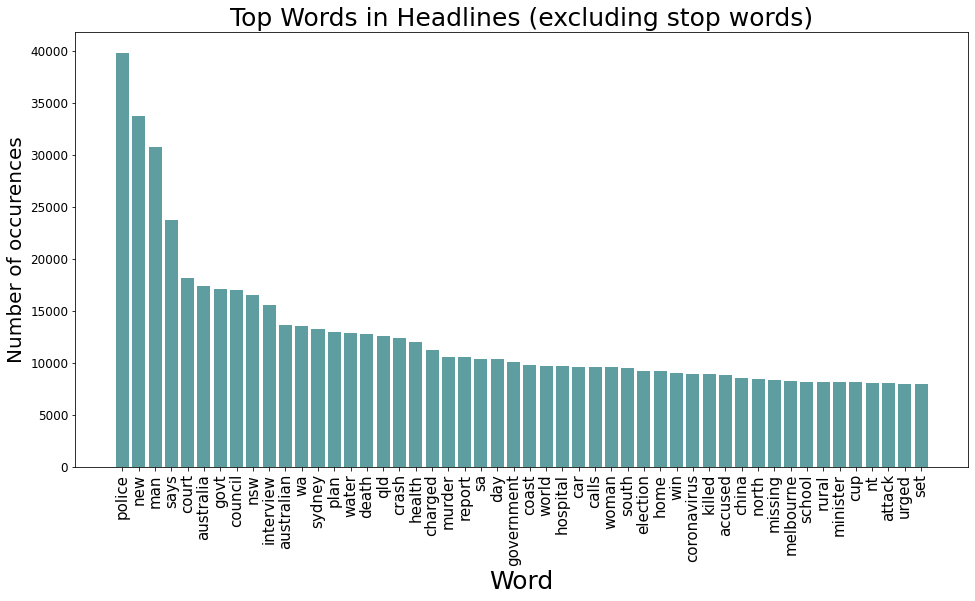

In [30]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=50,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=headlines_2)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values, color = "cadetblue");
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top Words in Headlines (excluding stop words)', fontsize = 25);
ax.set_xlabel('Word', fontsize = 25);
ax.set_ylabel('Number of occurences', fontsize = 20);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 12)
plt.show()

By plotting the number of headlines published per day, per month and per year, we can also get a sense of the sample density.

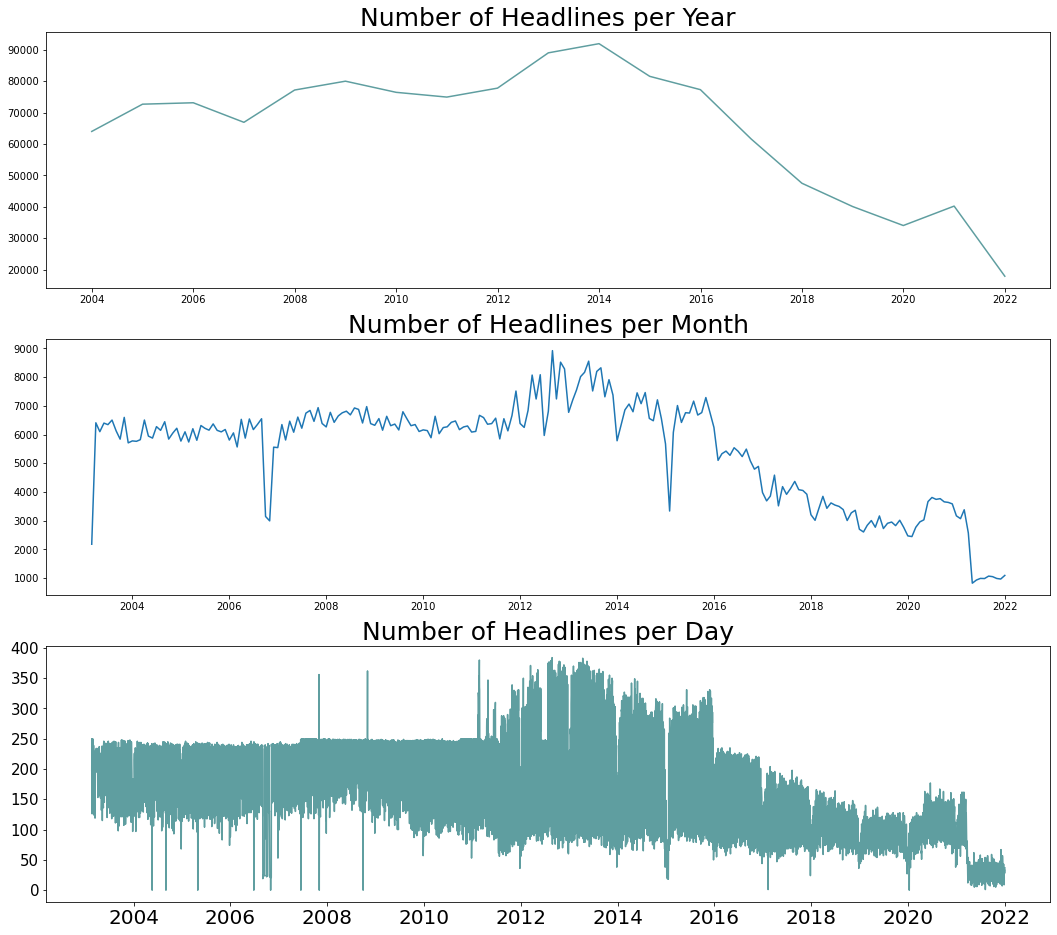

In [31]:
monthly_counts = headlines_2.resample('M').count()
yearly_counts = headlines_2.resample('A').count()
daily_counts = headlines_2.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[2].plot(daily_counts, color = "cadetblue");
ax[2].set_title('Number of Headlines per Day',fontsize = 25);
plt.xticks(fontsize = 20);
ax[1].plot(monthly_counts);
ax[1].set_title('Number of Headlines per Month',fontsize = 25);
ax[0].plot(yearly_counts, color = "cadetblue");
ax[0].set_title('Number of Headlines per Year', fontsize = 25);
plt.xticks(fontsize = 20);
plt.yticks(fontsize = 15)
plt.show()

## Topic Modelling
We now apply a clustering algorithm to the headlines corpus in order to study the topic focus of ABC News, as well as how it has evolved through time. To do so, we first experiment with a small subsample of the dataset in order to determine if LDA clustering algorithm is  appropriate – once this has been ascertained, we then scale up to a larger portion of the available data.

### Preprocessing
The only preprocessing step required in our case is feature construction, where we take the sample of text headlines and represent them in some tractable feature space. In practice, this simply means converting each string to a numerical vector. This can be done using the ```CountVectorizer``` object from SKLearn, which creates an $n×K$ document-term matrix where $K$ is the number of distinct words across the $n$ headlines in our sample (less stop words and with a limit of ```max_features```).

In [32]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = headlines_2.sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: leaders of womens group plan parliament march to
Headline after vectorization: 
  (0, 8434)	1
  (0, 6467)	1
  (0, 12467)	1
  (0, 5001)	1
  (0, 8151)	1
  (0, 6923)	1


Thus we have our (very high-rank and sparse) training data,  ```small_document_term_matrix```, and can now actually implement a  Latent Dirichilet Allocation (***LDA***) algorithm. This will take our document-term matrix as input and yield an $n \times N$ topic matrix as output, where $N$ is the number of topic categories (which we supply as a parameter). We set this as 10 topics.

In [33]:
n_topics = 10

Taking the $\arg \max$ of each headline in this topic matrix will give the predicted topics of each headline in the sample. We can then sort these into counts of each topic.

In [34]:
# Defining some functions

# returns an integer list of predicted topic categories for a given topic matrix
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

#returns a tuple of topic categories and their accompanying magnitudes for a given list of keys
def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

However, these topic categories are of themselves a little meaningless. In order to better characterise them, it will be helpful to find the most frequent words in each.

In [35]:
# Defining some functions

# returns a list of n_topic strings, where each string contains the n most common 
# words in a predicted category, in order
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

Thus we have converted our initial small sample of headlines into a list of predicted topic categories, where each category is characterised by its most frequent words. The relative magnitudes of each of these categories can then be easily visualised though use of a bar chart.

Now that we have reduced these ```n_topics```-dimensional vectors to two-dimensional representations, we can then plot the clusters using Bokeh. Before doing so however, it will be useful to derive the centroid location of each topic, so as to better contextualise our visualisation.

In [36]:
# Defining some functions
# returns a list of centroid vectors from each predicted topic category

def get_mean_topic_vectors(keys, two_dim_vectors):
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

All that remains is to plot the clustered headlines. Also included are the top three words in each cluster, which are placed at the centroid for that topic.

### Latent Dirichilet Allocation
LDA is a generative probabilistic process, designed with the specific goal of uncovering latent topic structure in text corpora.

In [37]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

Once again, we take the $\arg \max$ of each entry in the topic matrix to obtain the predicted topic category for each headline. These topic categories can then be characterised by their most frequent words.


In [38]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [39]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  govt cup plan day market world child final public local
Topic 2:  crash rural hospital national says killed fatal news iraq year
Topic 3:  health nsw wa australian action death abc sa urged wins
Topic 4:  australia qld coast council gold claims trump minister weather plans
Topic 5:  new help sydney farmers school group community residents case appeal
Topic 6:  police man charged car missing murder dies woman says assault
Topic 7:  interview council south home talks port test east return season
Topic 8:  court nt workers sex ban industry anti set media pm
Topic 9:  water win covid coronavirus melbourne 19 report mp gets labor
Topic 10:  man guilty north accused trial high west queensland threat rise


The relative topic compositions of the sample are then illustated with a barchart.

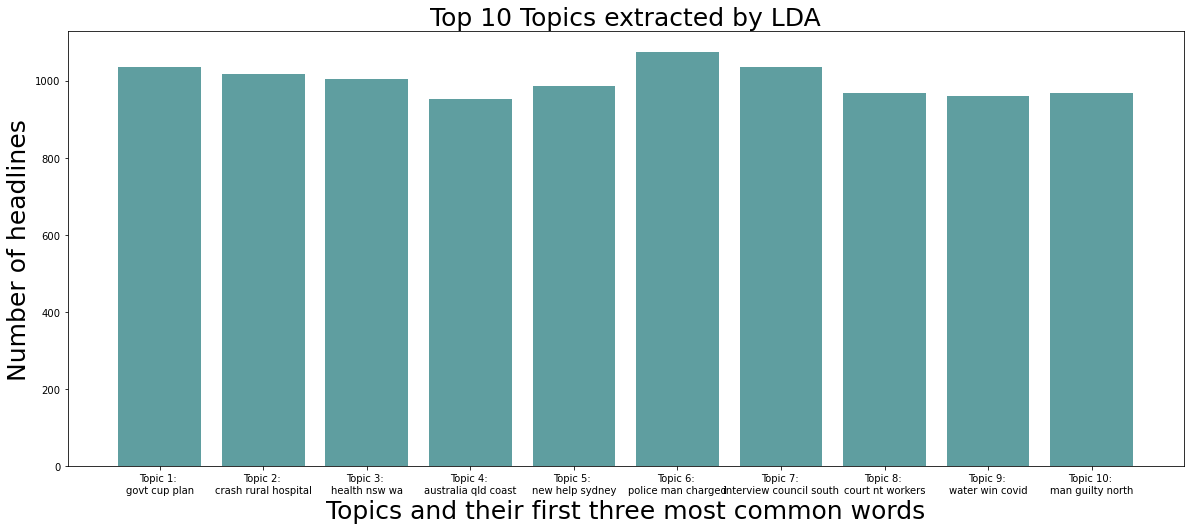

In [45]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i+1) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(20,8))
ax.bar(lda_categories, lda_counts, color = "cadetblue");
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels, fontsize = 10);
ax.set_title('Top 10 Topics extracted by LDA', fontsize = 25);
ax.set_xlabel('Topics and their first three most common words', fontsize = 25)
ax.set_ylabel('Number of headlines', fontsize = 25);

We can visually evaluate the success in LDA clustering algorithm using a dimensionality-reduction technique called $t$-SNE.

In [46]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.015s...
[t-SNE] Computed neighbors for 10000 samples in 1.752s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.361458
[t-SNE] KL divergence after 2000 iterations: 1.561866


In [47]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [48]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color="black")
    plot.add_layout(label)

show(plot)

Controlling for $t$-SNE, it would seem that LDA is suitable for separating out the topic categories. Therefore we can apply the algorithm on a bigger sample from the dataset.

### Scaling Up
Now that we have found an effective clustering algorithm, we can scale it up. We still have to work with a subsample, as it is infeasible to train an LDA model one million observations, but we can significantly increase our scope to $100,000$ headlines.


In [49]:
big_sample_size = 100000 

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_text_sample = headlines_2.sample(n=big_sample_size, random_state=0).values
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)


big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online')
big_lda_model.fit(big_document_term_matrix);

We thus have our big topic model. The next step is to pass the entire dataset of one million headlines through this model, and sort by years. This will allow us to develop a table of topic counts per year.

In [50]:
yearly_data = []
for i in range(2003,2021+1):
    yearly_data.append(headlines_2['{}'.format(i)].values)

yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    yearly_topic_matrices.append(topic_matrix)

yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2003,2021+1))
yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]

print(yearly_topic_counts)

      Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  Topic 8  \
2003     6350     6487     6617     6576     6079     6691     6397     6883   
2004     7358     7266     7385     6253     7683     7211     6947     6784   
2005     7756     6509     6677     8171     6376     7751     7905     7379   
2006     6488     6896     7567     7108     6650     7167     5840     6137   
2007     7824     7548     6455     8470     7113     7895     7888     8599   
2008     8157     8735     8769     8149     8499     7375     7249     7512   
2009     8553     7640     7009     7653     7841     8187     6389     7788   
2010     6668     8101     7041     7199     8417     7775     8166     7231   
2011     8216     7523     8137     7957     6970     8260     8030     7207   
2012    10089     8886     8699     9393     8493     9137     8250     8695   
2013     9801     9916     9110     8934     9566     9983     7905     9067   
2014     8813     7969     9020     7306

We now have a dataframe of the yearly counts of each of the $N$ topic categories, and can best visualise their evolution across time using a heatmap.

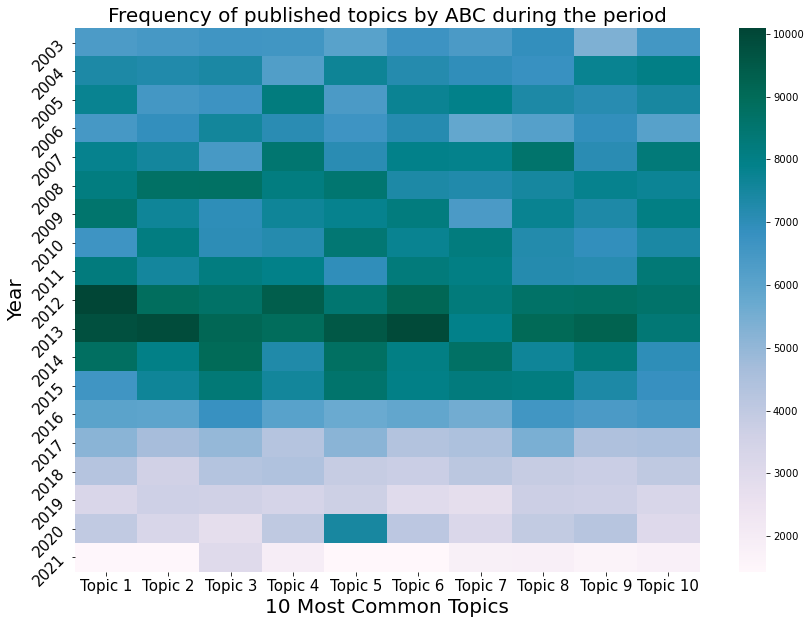

In [51]:
fig, ax = plt.subplots(figsize=(14,10))
sn.heatmap(yearly_topic_counts, cmap="PuBuGn", ax=ax);
ax.set_title('Frequency of published topics by ABC during the period', fontsize = 20);
ax.set_xlabel('10 Most Common Topics', fontsize = 20);
ax.set_ylabel('Year', fontsize = 20);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15, rotation = 45);
plt.show()

The full analysis of the results are discussed in the accompnying report.